# Distributed Word Representation

In [21]:
import numpy as np
from collections import Counter
import os
import string
import re
import itertools
from operator import itemgetter 
import matplotlib.pyplot as plt
from nltk.corpus import brown
import sys
import random
import time

In [2]:
path = './collection'

In [3]:
def tokenize_doc(doc, min_size=2):
    """
        doc: string

        return: list of strings
    """

    doc = doc.translate(str.maketrans("", "", string.punctuation))
    
    tokens = []
    
    for token in doc.split():
        if token in string.whitespace or token == '':
            continue
        if token != " ".join(re.findall("[a-zA-Z]+", token)):
            continue
        if len(token) < min_size:
            continue
        tokens.append(token.lower())

    return tokens

In [4]:
def collect(path):
    """
        path: string, relative path to dir with text samples

        return: list, tokenized documents
    """
    
    collection = []
    files = [os.path.join(path, file) for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))]
    
    for file in files[1:]:
        doc = open(file, "r")
        collection.append(tokenize_doc(doc.read()))
        
    return collection

In [5]:
def build_vocab(collection):
    """
        collection: list, tokenized documents

        return: dict str -> int
    """

    docs = list(itertools.chain.from_iterable(collection))
    docs.sort()
    vocab = {}
    index = 0
    
    for token in docs:
        if token in vocab.keys(): continue
        vocab[token] = index
        index += 1
    
    return vocab

In [6]:
def sigmoid(x):
    """
        x : np.float
        
        return :  np.float, sigm(x)
    """
    
    return 1. / (1 + np.exp(-x))

In [7]:
def objective(context, center, neg_sampling):
    """"
        context : np.array, array of words embeding in context
        center : center word embeging
        neg_sampling : np.array, array of words embedings sampled from unigram
        
        return : np.float, loss
    """
    exp = 1e-5
    
    context_loss = 0
    for context_embed in context: 
        context_loss += np.log(sigmoid(np.dot(context_embed, center))+exp)
#         print(context_embed, center, np.dot(context_embed, center))
    
    neg_sampling_loss = 0
    for neg_sampling_embed in neg_sampling: neg_sampling_loss += np.log(sigmoid(-np.dot(neg_sampling_embed, center))+exp)
    
    return - (context_loss + neg_sampling_loss)

In [8]:
def objective_backward(context, center, neg_sampling):
    """
        context : np.array, array of words embeding in context
        center : center word embeging"
        neg_sampling : np.array, array of words embedings sampled from unigram
        
        return :  np.array, gradients with respect to each parameter 
    """
    exp = 1e-5
    
    context_grad = []
    center_grad = np.zeros_like(center)
    
    for context_embed in context:
        context_grad.append(center * (sigmoid(np.dot(context_embed, center)) - 1))
        center_grad += context_embed * (sigmoid(np.dot(context_embed, center)) - 1)
        
    neg_sampling_grad = []
    for neg_sampling_embed in neg_sampling:
        neg_sampling_grad.append(center * sigmoid(np.dot(neg_sampling_embed, center)))
        context_grad += neg_sampling_embed * sigmoid(np.dot(neg_sampling_embed, center))
        
    return np.array(context_grad), center_grad, np.array(neg_sampling_grad)

In [16]:
def unigram_distribution(corpus, mapping, power=3/4):
    """
        corpus : list, tokenized document
        mapping : dict, str -> int
        
        return :  np.array, unigram distribution over vocab
    """
    
    counter = Counter()
    words_quantity = len(corpus)
    distribution = np.zeros(len(mapping.keys()))
    
    for token in corpus: counter[token] += 1
    for token in counter.keys(): distribution[mapping[token]] = counter[token] ** power
           
    return np.array(distribution / np.sum(distribution))

In [10]:
def generate_samples(distribution, num_samples):
    """
        distribution :  np.array, unigram distribution over vocab
        num_samples : int, number of samples to generate
        
        return : np.array, indexes of generated sampes (word in mapping)
    """
    
    vocab_len = len(distribution)
    
    return np.array([np.random.choice(np.arange(vocab_len), p=distribution) for _ in range(num_samples)])

In [11]:
def get_sample(index, corpus, mapping, window_width, num_samples):
    """
        index :  int, index of word under focus in corpus
        corpus : list, tokenized document
        mapping : dict, str -> int
        window_width : int, number of words in context
        num_samples : int, number of samples to generate
        
        
        return : np.array, indexes of context
                 int, index index of word under focus in mapping
                 np.array, indexes of generated sampes (word in mapping)
    """
    
    max_index = len(corpus)-1
    distribution = unigram_distribution(corpus, mapping)
    
    context_from, context_to = max(0, index - window_width), min(max_index, index + window_width+1)
    context = corpus[context_from:index]
    context.extend(corpus[index+1:context_to])
    
    context_indexes = np.array([mapping[context_word] for context_word in context])
    center_index = mapping[corpus[index]]
    neg_samples_indexes = generate_samples(distribution, num_samples)
    
    return context_indexes, center_index, neg_samples_indexes

In [12]:
def init_params(vocab_len, embed_size):
    """
        vocab_len : int, size of vocabulary 
        embed_size : int, word vector len
    
        return : list of np.array parameters
    """
    
    params_input = np.random.randn(vocab_len, embed_size) / embed_size
    params_output = np.random.randn(vocab_len, embed_size) / embed_size
    return [params_input, params_output]

def update_weights(params, context_indexes, center_index, neg_samples_indexes, learning_rate, embed_size):
    """
        params : np.array, weight matrix of word embedigs
                params[0] : np.array, input
                params[1] : np.array, output
        context_indexes : np.array, indexes of context words in mapping
        center_index : np.array, indexes of center word in mapping
        neg_samples_indexes : np.array, indexes of sampled words in mapping
        learning_rate : float
        embed_size : int, word vector len
        
        return : float, value of loss function
    """
    context, center, neg_samples = itemgetter(*context_indexes)(params[1]), params[0][center_index], itemgetter(*neg_samples_indexes)(params[1])
#     print (np.array(context).shape, np.array(center).shape, np.array(neg_samples).shape)
    context = np.array(context).reshape(-1, embed_size)
    center = np.array(center)
    neg_samples = np.array(neg_samples).reshape(-1, embed_size)
    loss = objective(context, center, neg_samples)
    context_grad, center_grad, neg_samples_grad = objective_backward(context, center, neg_samples)
    
    for index, grad in zip(context_indexes, context_grad):
        params[1][index] -= learning_rate * grad
        
    params[0][center_index] -= learning_rate * center_grad
    
    for index, grad in zip(neg_samples_indexes, neg_samples_grad):
        params[1][index] -= learning_rate * grad
        
    return loss

In [31]:
def train(init_params, update_func, mapping, collection, learning_rate=1e-2, learning_rate_to=None, embed_size=10, num_epoch=1, window_width=3, num_samples=7, plot_loss=False):
    """
        init_params : function to initialize params 
        update_func : function to update params
        mapping : dict, str -> int 
        collection : list of tokenized documents 
        learning_rate : float
        embed_size : int, size of word vector
        num_epoch : int
        window_width : int, number of word both from left and right in context 
        num_samples : int, number of word to generate from distribution
        plot_loss : bool
        
        return : list, collected after every corpus losses 
    """
    if learning_rate_to is not None:
        assert learning_rate > learning_rate_to, "Enter correct bounds for lr"
    
    losses = []
    vocab_len = len(mapping.keys())
    params = init_params(vocab_len, embed_size)
#     print(len(params))
    iter_count = len(list(itertools.chain.from_iterable(collection))) * num_epoch
    counter = 0
    for epoch in range(num_epoch):
        if learning_rate_to is not None:
            learning_rate -= (learning_rate - learning_rate_to) / num_epoch
        for corpus in collection:
            loss = 0 
            sys.stdout.write("progres: %d%%   \r" % (counter / iter_count * 100))
            sys.stdout.flush()
            for index, _ in enumerate(corpus):
                counter += 1
                context_indexes, center_index, neg_samples_indexes = get_sample(index, corpus, mapping, window_width, num_samples)
#                 print(context, center)
#                 print(context_indexes, center_index, neg_samples_indexes)
                loss += update_func(params, context_indexes, center_index, neg_samples_indexes, learning_rate, embed_size=embed_size)
#                 print(loss)
#             print(len(loss))
            losses.append(loss/len(corpus))
                
    if plot_loss:
        plt.plot(losses)
        plt.title("Loss")
        plt.xlabel("Iteration")
        plt.show()
        
    return losses, params

In [119]:
collection = collect(path)
mapping = build_vocab(collection)

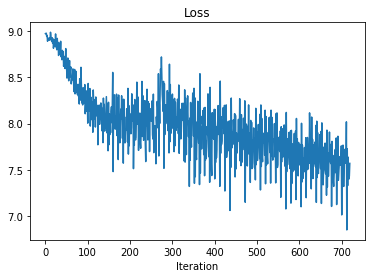

Execution time: 6.97 minuts


In [120]:
EMBED_SIZE = 30
start_time = time.time()
losses, params = train(init_params, update_weights, mapping, collection, num_epoch=60, embed_size=EMBED_SIZE, plot_loss=True, learning_rate=7e-2, learning_rate_to=1e-3, window_width=4, num_samples=5)
print("Execution time: {0:.2f} minuts".format((time.time() - start_time) / 60))


In [130]:
EOS = "eos"
EOS_embed = np.ones(2*len(params[0][0])).reshape(2,1,-1)

params = np.append(params, EOS_embed, axis=1)
mapping[EOS] = len(mapping.keys())

In [39]:
def softmax(z):
    """
        z: np.array

        return np.array, sm(z)
    """

    eps = 10e-10
    z = z - np.max(z)
    
    return np.exp(z) / (np.sum(np.exp(z)) + eps) 

In [40]:
def predict(params, word, mapping, context_size=5, mode="context"):
    """
    """
    assert mode in ["context", "center"], "No such mode"
    param_num = 1
    if mode == "center":
        param_num = 0
    assert word in mapping.keys(), "No such word in the vocabulary"
    input_embeding = params[0][mapping[word]]
    input_embeding.reshape(input_embeding.shape[0], -1)
    prediction = softmax(np.dot(params[param_num], input_embeding) / (np.sum(np.square(params[param_num]), axis=1)*np.sum(np.square(input_embeding))))
    indexes = prediction.argsort()[-context_size-1:][::-1]
    if mapping[word] in indexes:
        indexes = np.delete(indexes, np.where(indexes == mapping[word])[0][0])
    else:
        indexes = np.delete(indexes, -1)
    
    return indexes
    

In [145]:
word = list(mapping.keys())[random.randint(0, len(mapping))]
print("Context for '{}' is:".format(word))
predictions = predict(params, word, mapping)
for i, prediction in enumerate(predictions):
    print("{} : {}".format(i+1, list(mapping.keys())[prediction]))

Context for 'europeans' is:
1 : varangians
2 : continent
3 : reductions
4 : byzantium
5 : multifaceted


In [147]:
word = list(mapping.keys())[random.randint(0, len(mapping))]
print("Close to '{}' is:".format(word))
predictions = predict(params, word, mapping, mode="center")
for i, prediction in enumerate(predictions):
    print("{} : {}".format(i+1, list(mapping.keys())[prediction]))

Close to 'inventors' is:
1 : engineers
2 : needed
3 : acquired
4 : continuously
5 : redefined


In [102]:
def closest_word(embed, params, size=5):
    embed.reshape(embed.shape[0], -1)
    prediction = softmax(np.dot(params[0], embed) / (np.sum(np.square(params[0]), axis=1)*np.sum(np.square(embed))))
    indexes = prediction.argsort()[-size:][::-1]
    
    return indexes

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [82]:
def prepare_data(path, min_size=3):
    collection = []
    files = [os.path.join(path, file) for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))]
    
    for file in files[1:]:
        doc = open(file, "r").read()
        sentences = doc.split('.')
        for sentence in sentences:
            tokenized_sentence = tokenize_doc(sentence)
            if len(tokenized_sentence) < min_size:
                continue
            tokenized_sentence.append(EOS)
            tokenized_sentence.append(EOS)
            collection.append(tokenized_sentence)
        
    return collection

In [83]:
def sentens2embedings(sentence, params, mapping):
    embeds = []
    for word in sentence:
        embeds.append(params[0][mapping[word]])
    embeds = torch.tensor(embeds)
    
    return embeds.float()

In [84]:
class NextWordsPredictor(nn.Module):

    def __init__(self, embedding_dim, hidden_dim):
        super(NextWordsPredictor, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = sentens2embedings
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2embed = nn.Linear(hidden_dim, embedding_dim)

    def forward(self, sentence, params, mapping):
        embeds = self.word_embeddings(sentence, params, mapping)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        next_embed = self.hidden2embed(lstm_out.view(len(sentence), -1))
        return next_embed

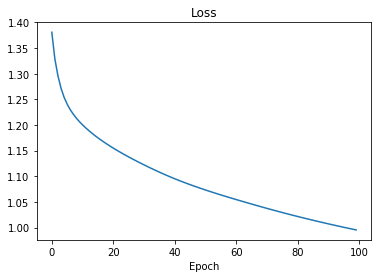

In [128]:
HIDDEN_SIZE = 30

model = NextWordsPredictor(EMBED_SIZE, HIDDEN_SIZE)
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

inputs = prepare_data(path)
# print(inputs)
losses = []
for epoch in range(100):  
    epoch_loss = 0
    for sentence in inputs:
        checker = False
        
        for word in sentence:
            if word not in list(mapping.keys()): 
                checker = True
#                 print(word)
        if checker: continue

        model.zero_grad()

        sentence_in = sentence[:-1]
        targets = sentens2embedings(sentence[1:], params, mapping)
        
        prediction = model(sentence_in, params, mapping)

        loss = loss_function(prediction, targets)
        epoch_loss += loss
        loss.backward()
        optimizer.step()
    losses.append(epoch_loss / len(inputs))


plt.plot(losses)
plt.title("Loss")
plt.xlabel("Epoch")
plt.show()


In [132]:
def closest_word(embed, params, prev):
    embed = embed.detach().numpy()
    embed.reshape(embed.shape[0], -1)
    prediction = softmax(np.dot(params[0], embed) / (np.sum(np.square(params[0]), axis=1)*np.sum(np.square(embed))))
    indexes = prediction.argsort()[-6:][::-1]
    if prev in indexes:
        indexes = np.delete(indexes, np.where(indexes == prev)[0][0])
    else:
        indexes = np.delete(indexes, -1)
    
    return indexes[random.randint(0, 4)]

In [133]:
def contunue_sentences(begining, params, mapping, max_length=30):
    words = []
    embed = model(begining, params, mapping)[-1]
    word = list(mapping.keys())[closest_word(embed, params, -1)]
    words.append(word)
    for _ in range(max_length-1):
        embed = model([word], params, mapping)[-1]
        word = list(mapping.keys())[closest_word(embed, params, mapping[words[-1]])]
        if word == EOS:
            break
        words.append(word)
        
    return words

In [148]:
sentence = [list(mapping.keys())[random.randint(0, len(mapping))]]
sentence.extend(contunue_sentences(sentence, params, mapping))
print(" ".join(sentence))

housing wage confucius abolitionist rendered example hosts foreign ninth embassies platos aristotles despite income despite postwar tr church tr agglomeration per education nazi tr lake broader immigration fourth airport postwar do
